In [6]:
import pandas as pd
import re
import json
# Cargar ingredientes normalizados
ingredientes_totales = pd.read_csv("ingredientes+huella.csv", usecols=["ingredient_normalized"], sep=";")

# Cargar productos
file_path = '../data/raw/products_utf8.csv'
productos = pd.read_csv(file_path, usecols=["ingredients_text"], encoding='utf-8')

In [9]:

# Limpiar y estandarizar la lista de ingredientes normalizados
ingredientes_set = set(ingredientes_totales['ingredient_normalized']
                       .dropna()
                       .str.lower()
                       .str.strip()
                       .apply(lambda x: re.sub(r'[^\w\s]', '', x)))  # Eliminar caracteres especiales

# Función para buscar ingredientes en el texto ambiguo
def identificar_ingredientes(texto, ingredientes_set):
    if pd.isna(texto):
        return []
    texto = texto.lower()  # Convertir a minúsculas
    texto = re.sub(r'[\(\)\[\]\d\%]', '', texto)  # Limpiar caracteres no deseados
    palabras = re.split(r'[ ,;:]', texto)  # Separar por espacios, comas, punto y coma, etc.
    ingredientes_encontrados = [palabra.strip() for palabra in palabras if palabra.strip() in ingredientes_set]
    return list(set(ingredientes_encontrados))  # Eliminar duplicados

# Aplicar la función a toda la base de datos
productos['ingredientes_identificados'] = productos['ingredients_text'].apply(lambda x: identificar_ingredientes(x, ingredientes_set))

# Seleccionar columnas relevantes
resultado = productos[['ingredients_text', 'ingredientes_identificados']]

# Guardar el resultado en un archivo JSON
resultado_json = resultado.to_json(orient='records', indent=2, force_ascii=False)
with open("productos_ingredientes_identificados.json", "w", encoding="utf-8") as file:
    file.write(resultado_json)

# Confirmación y muestra de ejemplo
print("El archivo 'productos_ingredientes_identificados.json' ha sido generado con éxito.")
print(resultado.head())


El archivo 'productos_ingredientes_identificados.json' ha sido generado con éxito.
              ingredients_text ingredientes_identificados
0                      Cheddar                         []
1  Butter (Milk), Salt (1.5%).             [butter, milk]
2               Salmon (Fish).                         []
3         Clementine, Mandarin                         []
4                      Avocado                         []


Código para analizar frecuencias y graficar

Total de ingredientes identificados: 34
  Ingrediente  Frecuencia
0        milk       14532
1       onion       13458
2      butter       11675
3        rice        9951
4      tomato        9786
El archivo 'frecuencia_ingredientes.csv' ha sido generado con éxito.


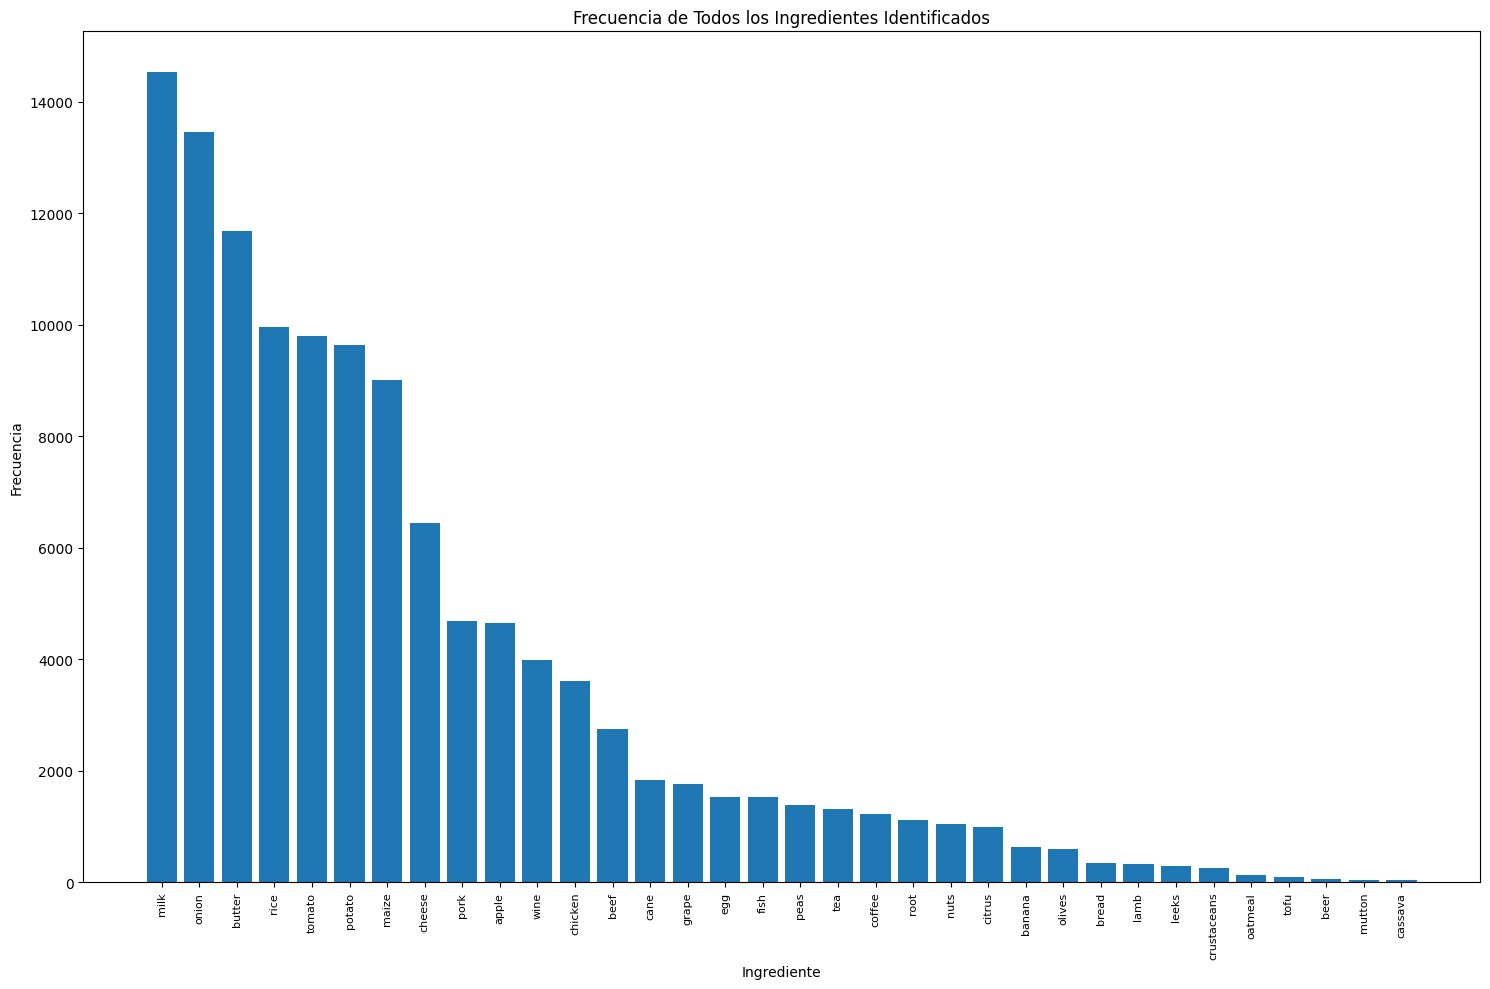

In [13]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Cargar el archivo JSON generado previamente
with open("productos_ingredientes_identificados.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Convertir a un DataFrame
df = pd.DataFrame(data)

# Aplanar la lista de ingredientes identificados en una sola lista
ingredientes_lista = df['ingredientes_identificados'].explode()

# Calcular las frecuencias de cada ingrediente
frecuencias = ingredientes_lista.value_counts().reset_index()
frecuencias.columns = ['Ingrediente', 'Frecuencia']

# Mostrar el número total de ingredientes identificados y una muestra
print(f"Total de ingredientes identificados: {frecuencias.shape[0]}")
print(frecuencias.head())

# Guardar las frecuencias en un archivo CSV
frecuencias.to_csv("frecuencia_ingredientes.csv", index=False)
print("El archivo 'frecuencia_ingredientes.csv' ha sido generado con éxito.")

# Crear un diagrama de barras con todas las frecuencias
plt.figure(figsize=(15, 10))
plt.bar(frecuencias['Ingrediente'], frecuencias['Frecuencia'])
plt.xticks(rotation=90, fontsize=8)
plt.title("Frecuencia de Todos los Ingredientes Identificados")
plt.xlabel("Ingrediente")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


Frecuencia del número de ingredientes por producto:
    Número de Ingredientes  Frecuencia
0                        0       48038
1                        1       21335
2                        2       14148
3                        3        7878
4                        4        4872
5                        5        2958
6                        6        1065
7                        7         518
8                        8         211
9                        9          74
10                      10          38
11                      11          26
12                      12           2
14                      13           1
13                      14           2
El archivo 'frecuencia_ingredientes_por_producto.csv' ha sido generado con éxito.


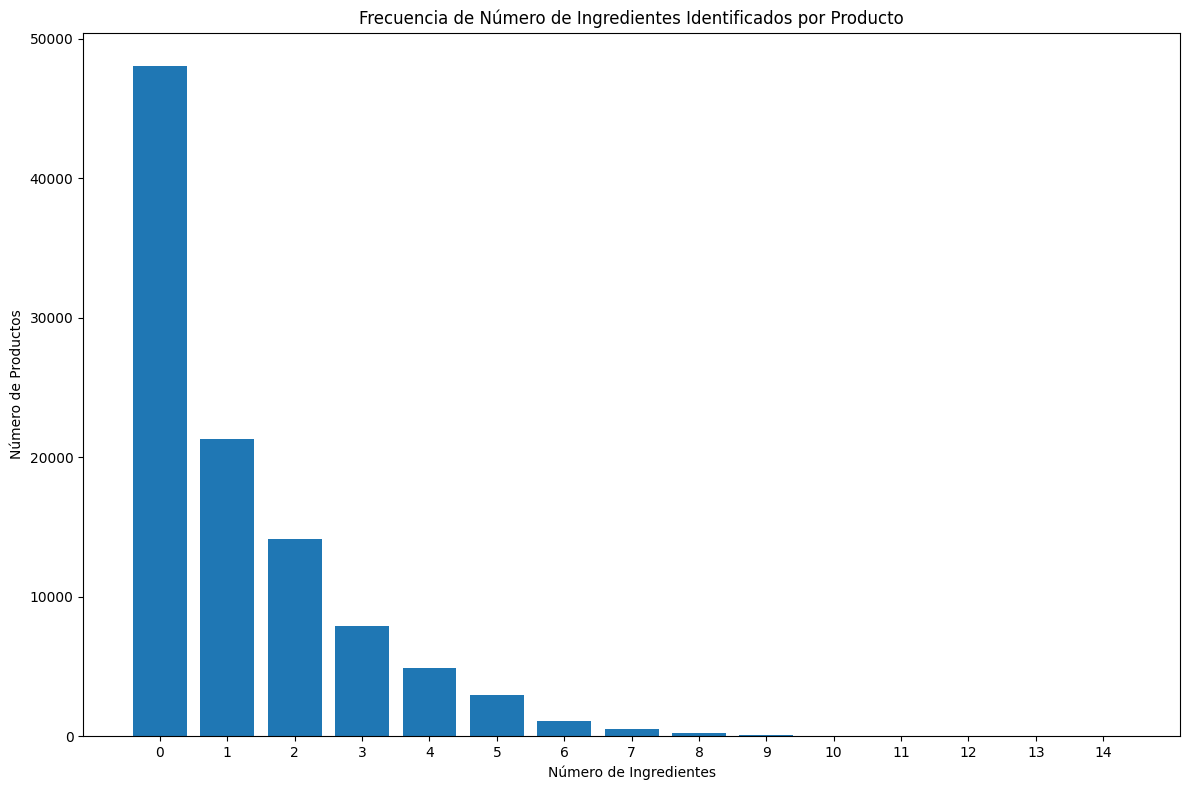

In [14]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Cargar el archivo JSON generado previamente
with open("productos_ingredientes_identificados.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Convertir a un DataFrame
df = pd.DataFrame(data)

# Calcular el número de ingredientes identificados por producto
df['num_ingredientes'] = df['ingredientes_identificados'].apply(lambda x: len(x))

# Calcular las frecuencias del número de ingredientes
frecuencia_productos = df['num_ingredientes'].value_counts().reset_index()
frecuencia_productos.columns = ['Número de Ingredientes', 'Frecuencia']
frecuencia_productos = frecuencia_productos.sort_values(by='Número de Ingredientes')

# Mostrar la tabla de frecuencias
print("Frecuencia del número de ingredientes por producto:")
print(frecuencia_productos)

# Guardar las frecuencias en un archivo CSV
frecuencia_productos.to_csv("frecuencia_ingredientes_por_producto.csv", index=False)
print("El archivo 'frecuencia_ingredientes_por_producto.csv' ha sido generado con éxito.")

# Crear un diagrama de barras
plt.figure(figsize=(12, 8))
plt.bar(frecuencia_productos['Número de Ingredientes'], frecuencia_productos['Frecuencia'])
plt.title("Frecuencia de Número de Ingredientes Identificados por Producto")
plt.xlabel("Número de Ingredientes")
plt.ylabel("Número de Productos")
plt.xticks(frecuencia_productos['Número de Ingredientes'])
plt.tight_layout()
plt.show()


ESTE NO HACE FALTA CORRERLO

In [16]:
import pandas as pd
import json
import os

# Cargar el archivo JSON generado previamente
with open("productos_ingredientes_identificados.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Convertir a un DataFrame
df = pd.DataFrame(data)

# Calcular el número de ingredientes identificados por producto
df['num_ingredientes'] = df['ingredientes_identificados'].apply(lambda x: len(x))

# Crear un directorio para almacenar los archivos
output_dir = "productos_por_frecuencia"
os.makedirs(output_dir, exist_ok=True)

# Crear un diccionario para almacenar los JSON finales
productos_json = {}

# Filtrar y guardar los productos según su frecuencia
for freq in sorted(df['num_ingredientes'].unique()):
    etiqueta = f"freq{freq}"
    productos_freq = df[df['num_ingredientes'] == freq]
    
    # Guardar como CSV
    csv_file = os.path.join(output_dir, f"productos_{etiqueta}.csv")
    productos_freq.to_csv(csv_file, index=False)
    
    # Guardar como JSON y añadir al diccionario
    productos_json[etiqueta] = productos_freq.to_dict(orient='records')
    json_file = os.path.join(output_dir, f"productos_{etiqueta}.json")
    with open(json_file, "w", encoding="utf-8") as jf:
        json.dump(productos_json[etiqueta], jf, indent=2, ensure_ascii=False)
    
    print(f"Generado {csv_file} y {json_file}")

# Guardar un CSV final con etiquetas de frecuencia
df['etiqueta_frecuencia'] = df['num_ingredientes'].apply(lambda x: f"freq{x}")
csv_file_general = os.path.join(output_dir, "productos_etiquetados_frecuencia.csv")
df.to_csv(csv_file_general, index=False)
print(f"Archivo general guardado en: {csv_file_general}")

# Guardar JSON completo con todos los productos etiquetados
json_general_file = os.path.join(output_dir, "productos_etiquetados_frecuencia.json")
with open(json_general_file, "w", encoding="utf-8") as jf:
    json.dump(df.to_dict(orient='records'), jf, indent=2, ensure_ascii=False)
print(f"JSON general guardado en: {json_general_file}")


Generado productos_por_frecuencia\productos_freq0.csv y productos_por_frecuencia\productos_freq0.json
Generado productos_por_frecuencia\productos_freq1.csv y productos_por_frecuencia\productos_freq1.json
Generado productos_por_frecuencia\productos_freq2.csv y productos_por_frecuencia\productos_freq2.json
Generado productos_por_frecuencia\productos_freq3.csv y productos_por_frecuencia\productos_freq3.json
Generado productos_por_frecuencia\productos_freq4.csv y productos_por_frecuencia\productos_freq4.json
Generado productos_por_frecuencia\productos_freq5.csv y productos_por_frecuencia\productos_freq5.json
Generado productos_por_frecuencia\productos_freq6.csv y productos_por_frecuencia\productos_freq6.json
Generado productos_por_frecuencia\productos_freq7.csv y productos_por_frecuencia\productos_freq7.json
Generado productos_por_frecuencia\productos_freq8.csv y productos_por_frecuencia\productos_freq8.json
Generado productos_por_frecuencia\productos_freq9.csv y productos_por_frecuencia\p